In [1]:
#########################################################################
# Artificial Neural Network - Video Game Success Prediction
#########################################################################

In [2]:
#########################################################################
# Import Libraries
#########################################################################
# Current stable release for CPU and GPU
!pip install tensorflow

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from IPython.display import display, HTML
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#########################################################################
# Import Data
#########################################################################

# import data
data_for_model = pd.read_csv("ann-game-data.csv")

# drop any redundant columns
data_for_model.drop("player_id", axis = 1, inplace = True)

data_for_model

,level,clan,ammo,lithium,neon,karma,success
0,1,Ork,17,6,11,62,0
1,19,Ork,77,16,3,58,1
2,4,Human,4,1,10,66,0
3,1,Ork,1,18,17,69,0
4,1,Elf,10,17,17,67,0
...,...,...,...,...,...,...,...
3995,6,Elf,16,4,10,67,0
3996,8,Human,5,0,10,64,0
3997,5,Elf,20,0,9,57,1
3998,12,Elf,34,5,8,48,1


In [4]:
#########################################################################
# Split Input Variables & Output Variable
#########################################################################

X = data_for_model.drop(["success"], axis = 1)
y = data_for_model["success"]

In [5]:
#########################################################################
# Split out Training & Test sets
#########################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) #stratify = y ensures balance of data across test and training


In [6]:
#########################################################################
# Deal with Categorical Variables
#########################################################################

categorical_vars = ["clan"]

one_hot_encoder = OneHotEncoder(sparse=False, drop = "first") #Drop helps us to avoid multicollinearity, though this is less of a concern in NN, so this could be out
#This would result in three encoded columns, each for elf, human, and ork
#If human and ork rows are 0, this means elf

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)


C:\Users\19144\anaconda4\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
print(X_train)

      level  ammo  lithium  neon  karma  clan_Human  clan_Ork
0        10    69        5     8     54         0.0       1.0
1         5     2        8    12     74         0.0       1.0
2         2    16        0    10     75         0.0       1.0
3         6    10        0    10     59         0.0       0.0
4        11    10        7     8     59         0.0       1.0
...     ...   ...      ...   ...    ...         ...       ...
3195      5    11       14    15     86         1.0       0.0
3196      9    13       10     6     54         0.0       1.0
3197      7     6        3    10     83         0.0       1.0
3198      1    11       16    16     70         0.0       1.0
3199      3     5        6    11     63         1.0       0.0

[3200 rows x 7 columns]


In [8]:
#########################################################################
# Feature Scaling
#########################################################################

scale_norm = MinMaxScaler()
X_train = pd.DataFrame(scale_norm.fit_transform(X_train), columns = X_train.columns) 
X_test = pd.DataFrame(scale_norm.transform(X_test), columns = X_test.columns)


In [9]:
X_train #All variables are between 0-1 now

,level,ammo,lithium,neon,karma,clan_Human,clan_Ork
0,0.290323,0.345178,0.263158,0.411765,0.228070,0.0,1.0
1,0.129032,0.005076,0.421053,0.647059,0.578947,0.0,1.0
2,0.032258,0.076142,0.000000,0.529412,0.596491,0.0,1.0
3,0.161290,0.045685,0.000000,0.529412,0.315789,0.0,0.0
4,0.322581,0.045685,0.368421,0.411765,0.315789,0.0,1.0
...,...,...,...,...,...,...,...
3195,0.129032,0.050761,0.736842,0.823529,0.789474,1.0,0.0
3196,0.258065,0.060914,0.526316,0.294118,0.228070,0.0,1.0
3197,0.193548,0.025381,0.157895,0.529412,0.736842,0.0,1.0
3198,0.000000,0.050761,0.842105,0.882353,0.508772,0.0,1.0


In [10]:
#########################################################################
# Network Architecture
#########################################################################

# network architecture

model = Sequential() #Instantiate model, number of features

#First layer
model.add(Dense(units = 32, input_dim=X_train.shape[1])) 
#First hidden layer - 32 units/neurons for first layer - this is a first guess, input_dim - 7 columns, but we can set this to number of columns on X_train
model.add(Activation('relu')) 
#Relu activation function - how to dictate to subsequent layers

#Second hidden layer
model.add(Dense(units = 32)) 
model.add(Activation('relu')) 
          
#Output layer
model.add(Dense(units = 1)) 
model.add(Activation('sigmoid')) 
#We have 2 possible outcomes in this data set - 0,1
#We are interested in 1 outcome, so units=1 - probability each observation belonging to positive class
            

# compile network

model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# view network architecture

model.summary()

#Layer type and layer name, shape is number of neurons, on right are the parameters
#Trainable params = 1,345 - # of parameters that will be trained when back propogation runs
#256+1,056+33 = 1,345


C:\Users\19144\anaconda4\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#What does 256 mean in top right corner?
#Represents connections between input neurons and first layer
#7 input neurons, 32 neurons in hidden layer 1, 32 neurons in hidden layer 2, and 1 output layer
#7 input neurons X 32 neurons = 224 /32 neurons in first layer, so then 32 bias values/ 224+32 = 256

#What about 1,056?
#Represents connections between hidden layer 1 and hidden layer 2
#32 neurons from hidden layer 1, X 32 neurons in hidden layer 2 = 1,024 + 32 bias values from hidden layer 2 =  1,056

#What about 33?
#HL2 = We have 32 connections + 1 bias value (output value) = 33


In [12]:
#########################################################################
# Train Our Network!
#########################################################################

# training parameters

num_epochs =50 #We will pass all observations in training set through network 50 times before we are done - we don't know if this is too many or too little at this stage
batch_size = 32 #32 observations from training data will be passed through network, loss will be calculated, back propogation will kick in
model_filename = 'C:\\Users\\19144\\OneDrive\\Desktop\\Data Science Infinity\\Deep Learning\\video_game_ann.keras'

# callbacks
#A function that will be applied during specified points in training

save_best_model = ModelCheckpoint(filepath = model_filename,
                                 monitor= 'val_accuracy', #Monitor what metric to assess to track performance - can use val_loss too     
                                 mode = 'max', #We want max here - for val_loss, we'd want min
                                 verbose = 1,  #During training we will be notified if/when a better model has been found and updates model file
                                 save_best_only=True) #Save best only
# train the network

history = model.fit(x=X_train.values,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    batch_size=batch_size, 
                    epochs = num_epochs,
                    callbacks = [save_best_model])

#########################################################################
# Visualise Training & Validation Performance
#########################################################################


Epoch 1/50
 61/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6517 - loss: 0.6568    
Epoch 1: val_accuracy improved from -inf to 0.83250, saving model to C:\Users\19144\OneDrive\Desktop\Data Science Infinity\Deep Learning\video_game_ann.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6757 - loss: 0.6406 - val_accuracy: 0.8325 - val_loss: 0.4682
Epoch 2/50
 75/100 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.8578 - loss: 0.4222
Epoch 2: val_accuracy improved from 0.83250 to 0.91000, saving model to C:\Users\19144\OneDrive\Desktop\Data Science Infinity\Deep Learning\video_game_ann.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8606 - loss: 0.4078 - val_accuracy: 0.9100 - val_loss: 0.2555
Epoch 3/50
 69/100 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.9039 - loss: 0.2569
Epoch 3: val_accuracy improved from 0.91000 to 0.91125, saving model to C:\Users\19144\OneDrive\Desktop\Data Science Infinity\Deep Learning\video_game_ann.keras
100/100 ━━━━━━━━━━━━

In [13]:
#Accuracy and loss are on the training set, val accuracy and vall loss are on the test set
#NN output is different among users slightly...but numbers should be similar


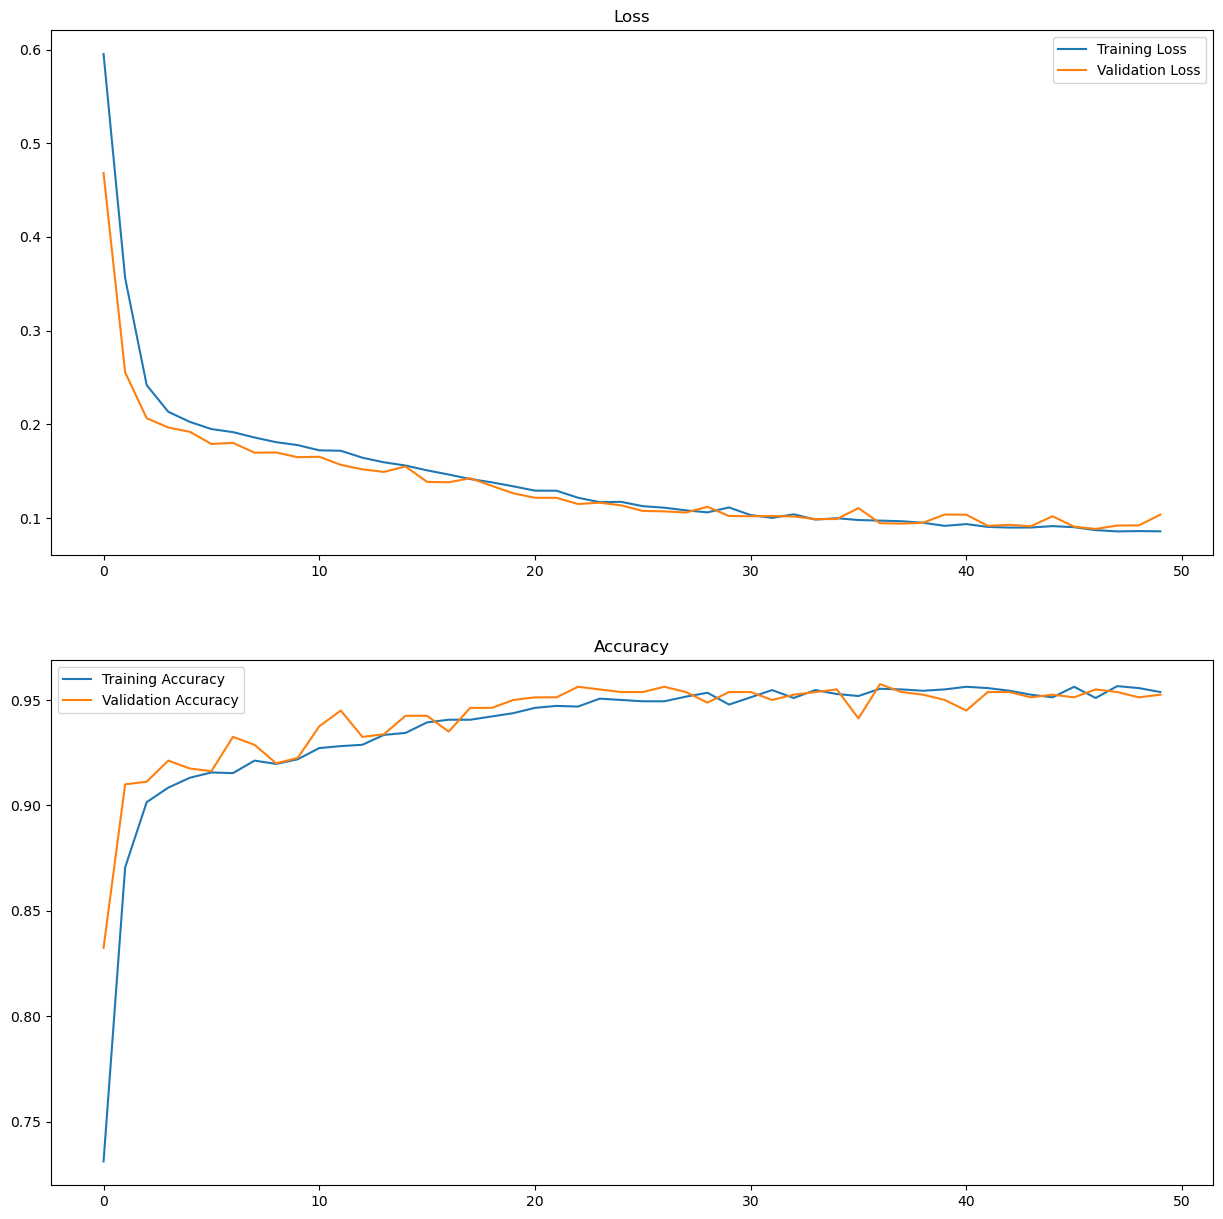

0.9574999809265137

In [14]:
# plot metrics by epoch
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()

# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])


In [15]:
#Each epoch as at the bottom of each chart
#As loss falls, accuracy improves - both charts should mirror each other

#We're getting to best performance around 30 epochs or so
#There isn't much of a gap between two lines on both charts...if we see a big gap, it means our network may be overfitting
#If we saw training set accuracy higher than validation set accuracy, this is also a sign of overfitting...network is learning training data set rules so well, it is struggling to perform on unseen data
#If this happens, we could do dropout...ignore neurons in layers...this can prevent overlearning...forces network to generalize


In [16]:

#########################################################################
# Make Predictions On New Data
#########################################################################

# import packages

from tensorflow.keras.models import load_model

# load model

model = load_model(model_filename)

# create new data

list(X_train)

player_a = [[9,30,6,11,62,0,1]] #Pass in multiple observations at once, these numbers are written in the order of X_train data
player_a = scale_norm.transform(player_a)
player_a



C:\Users\19144\anaconda4\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.25806452, 0.14720812, 0.31578947, 0.58823529, 0.36842105,
        0.        , 1.        ]])

In [17]:
#Make prediction

prediction = model.predict(player_a)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0.11516662]]


In [ ]:
#11% that this player will succeed in this level

In [19]:
player_b = [[11,27,0,9,59,0,0]]
player_b = scale_norm.transform(player_b)
prediction = model.predict(player_b)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.8426772]]


C:\Users\19144\anaconda4\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [20]:
#84% that this player will succeed in this level

In [21]:
prediction_class = (prediction >=0.5)*1
print(prediction_class)
#Boolean value whether value is greater/equal to 0.5 or not
#Prediction for player B, this menas classified as a success

[[1]]
